In [6]:
import os
import time
import warnings
from copy import deepcopy
from collections import OrderedDict
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from hdf5storage import loadmat, savemat

import pycochleagram.cochleagram as cgram

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as tdist

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.enable_validation(True)
pyro.clear_param_store()

from tools.experiment_neural import stim_tr, stim_vl, data_tr, data_vl, stim_tx, data_tx
from tools.data_librispeech import LibriDataset, load_subset, cgram_params
from tools.nsr_utils import train_nsr, validate_nsr, Experiment

cuda = torch.cuda.is_available() and False
print("cuda" if cuda else "cpu")

cpu


In [7]:
window = 20
dilation = 1
downsample = 8

X = [torch.from_numpy(x)[:,:] for x in stim_tr]
X = [F.avg_pool1d(x.unsqueeze(0), downsample).squeeze(0) for x in X]
X = [F.unfold(F.pad(x, (0,0,(window-1)*dilation,0)).T.unsqueeze(0).unsqueeze(-1), (window,1), dilation).squeeze(0).squeeze(-1).T for x in X]
Y = [torch.from_numpy(y[:,:]) for y in data_tr]
print(X[0].shape, Y[0].shape, round(sp.stats.pearsonr(X[0].mean(-1), Y[0][:,29])[0], 3))

X_test = [torch.from_numpy(x) for x in stim_vl]
X_test = [F.avg_pool1d(x.unsqueeze(0), downsample).squeeze(0) for x in X_test]
X_test = [F.unfold(F.pad(x, (0,0,(window-1)*dilation,0)).T.unsqueeze(0).unsqueeze(-1), (window,1), dilation).squeeze(0).squeeze(-1).T for x in X_test]
Y_test = [torch.from_numpy(y[:,:,:].mean(-1)) for y in data_vl]
print(X_test[0].shape, Y_test[0].shape, round(sp.stats.pearsonr(X_test[0].mean(-1), Y_test[0][:,29])[0], 3))

# eps = 2
# min_y = min(min(torch.cat(Y)), min(torch.cat(Y_test)))
# Y = [y+min_y+eps for y in Y]
# Y_test = [y+min_y+eps for y in Y_test]

num_frames = len(X)
xdim = X[0].shape[-1]
ydim = Y[0].shape[-1] if Y[0].ndim > 1 else 1

dt = 1e-2
print(f'{sum([len(x) for x in X])*dt/60:.2f} minutes')
print(f'{sum([len(x) for x in X_test])*dt:.2f} seconds')
# plt.plot(X[0])
# plt.plot(Y[0])
# plt.show()

torch.Size([6097, 160]) torch.Size([6097, 404]) 0.507
torch.Size([500, 160]) torch.Size([500, 404]) 0.544
29.98 minutes
40.00 seconds


In [8]:
locz = loadmat('/home/menoua/Data/lingo.mat')['loc'][0,0]
ind_hg = locz["hg"].flatten().astype("bool")
ind_pt = locz["pt"].flatten().astype("bool")
ind_stg = locz["stg"].flatten().astype("bool")
ind_mtg = locz["mtg"].flatten().astype("bool")
ind_itg = locz["itg"].flatten().astype("bool")
ind_sfg = locz["sfg"].flatten().astype("bool")
ind_prc = locz["precentral"].flatten().astype("bool")
ind_psc = locz["postcentral"].flatten().astype("bool")
ind_ins = locz["insula"].flatten().astype("bool")
del locz

U = X
Z = [_[:,ind_hg] for _ in Y]
udim, zdim = U[0].shape[-1], Z[0].shape[-1]

In [4]:
def kalman_filter(udim, xdim, zdim, cuda=False):
    device = "cuda" if cuda else "cpu"
    
    def model(u, z):
        u, z = u.to(device), z.to(device)
        # a HalfNormal or HalfCauchy can be used here
        Q = 0.1*torch.ones(xdim, device=device)
        R = 0.1*torch.ones(zdim, device=device)
        
        # State transition matrix
        con1, con0 = torch.tensor(2.5, device=device), torch.tensor(2.5, device=device)
        with pyro.plate("plate_F", xdim):
            F = pyro.sample("state_transition", dist.Beta(con1, con0))
        F = torch.diag(F)
        
        # External input transition matrix
        loc, scale = torch.zeros(1,device=device), 0.1*torch.ones(1,device=device)
        with pyro.plate("plate_G", xdim*udim):
            G = pyro.sample("input_transition", dist.Normal(loc, scale))
        G = G.reshape(xdim,udim)
        
        # Measurement transition matrix
        scale = 1.0*torch.ones(1,device=device)
        with pyro.plate("plate_measurement", zdim*xdim):
            H = pyro.sample("measurement_transition", dist.HalfNormal(scale))
        H = H.reshape(zdim,xdim)
        
        # Measurement bias
        loc, scale = torch.zeros(1,device=device), 0.2*torch.ones(1,device=device)
        with pyro.plate("plate_bias", zdim):
            bias = pyro.sample("measurement_bias", dist.Normal(loc, scale))
        
        # Prepare time series variables
        time_steps = len(u)
        X, Z = [], []
        
        # Initialize state
        X0 = torch.zeros(xdim, device=device)
        
        # Loop through time series
        for t in range(time_steps):
            # Predict next step
            loc = G @ u[t,:] + F @ (X0 if t==0 else X[t-1])
            with pyro.plate(f'plate_state_{t}', xdim):
                X += [pyro.sample(f'state_{t}', dist.Normal(loc, Q))]
            
            # Measure
            loc = H @ X[t] + bias
            with pyro.plate(f'measurement_{t}', zdim):
                Z += [pyro.sample(f'obs_{t}', dist.Normal(loc, R), obs=z[t,:])]
    
    params = ["state_transition", "input_transition", "measurement_transition", "measurement_bias"]
    guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(model, expose=params))
    
    return model, guide

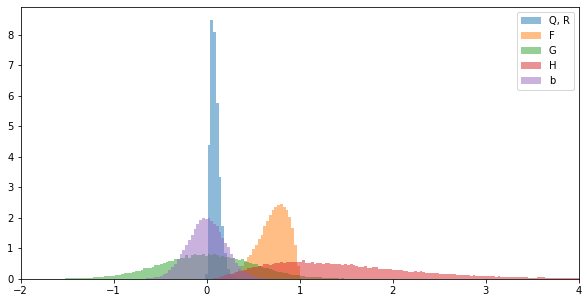

In [310]:
plt.figure(figsize=(10,5))

# Fallback distribution
D = dist.Gamma(1.0, 1.0)

# Q, R
D = dist.Beta(3.0, 30.0)
plt.hist([D.sample() for _ in range(50_000)], range=(-2,4), bins=200, density=True, alpha=0.5);

# F
D = dist.Beta(5.0, 2.0)
plt.hist([D.sample() for _ in range(50_000)], range=(-2,4), bins=200, density=True, alpha=0.5);

# G
D = dist.Normal(0.0, 0.5)
plt.hist([D.sample() for _ in range(50_000)], range=(-2,4), bins=200, density=True, alpha=0.5);

# H
D = dist.Gamma(3.0, 2.0)
plt.hist([D.sample() for _ in range(50_000)], range=(-2,4), bins=200, density=True, alpha=0.5);

# b
D = dist.Normal(0.0, 0.2)
plt.hist([D.sample() for _ in range(50_000)], range=(-2,4), bins=200, density=True, alpha=0.5);

plt.legend(['Q, R', 'F', 'G', 'H', 'b'])
plt.xlim(-2, 4)
plt.show()

In [311]:
# Let's start with a simple linear dynamical model.
#
#     x[t-1] --> x[t] --> x[t+1]
#        |        |         |
#        V        V         V
#     y[t-1]     y[t]     y[t+1]

def kalman_filter_0(udim, xdim, zdim, cuda=False):
    device = "cuda" if cuda else "cpu"
    
    def model(u_seq, z_seq, batch_size=None):
        # Move input and output to model device
        u_seq = list(map(lambda x: x.to(device), u_seq))
        z_seq = list(map(lambda x: x.to(device), z_seq))
        
        # Process sequence lengths
        lengths = list(map(len, u_seq))
        num_sequences, max_length = len(lengths), max(lengths)
        
        plate_u1, plate_u2 = pyro.plate("plate_u1", udim, dim=-1), pyro.plate("plate_u2", udim, dim=-2)
        plate_x1, plate_x2 = pyro.plate("plate_x1", xdim, dim=-1), pyro.plate("plate_x2", xdim, dim=-2)
        plate_z1, plate_z2 = pyro.plate("plate_z1", zdim, dim=-1), pyro.plate("plate_z2", zdim, dim=-2)
        plate_seq = pyro.plate("plate_seq", num_sequences, batch_size)
        
        # Parameter priors
        #with poutine.mask(mask=True):
        with plate_x1:
            # State noise covariance
            Q = pyro.sample("Q", dist.Beta(torch.tensor(3.0, device=device),
                                           torch.tensor(30.0, device=device)))
        
        with plate_z1:
            # Measurement noise covariance
            R = pyro.sample("R", dist.Beta(torch.tensor(3.0, device=device),
                                           torch.tensor(30.0, device=device)))
        
        with plate_x2, plate_x1:
            # State transition matrix
            F = pyro.sample("F", dist.Beta(torch.tensor(5.0, device=device),
                                           torch.tensor(2.0, device=device)))
        
        with plate_x2, plate_u1:
            # Input filter matrix
            G = pyro.sample("G", dist.Normal(torch.tensor(0.0, device=device),
                                             torch.tensor(0.5, device=device)))
        
        with plate_z2, plate_x1:
            # Measurement matrix
            H = pyro.sample("H", dist.Gamma(torch.tensor(3.0, device=device),
                                            torch.tensor(2.0, device=device)))
        
        with plate_z1:
            # Measurement bias
            b = pyro.sample("b", dist.Normal(torch.tensor(0.0, device=device),
                                             torch.tensor(0.2, device=device)))
        
        # In this first model we'll sequentially iterate over sequences in a
        # minibatch; this will make it easy to reason about tensor shapes.
        for i in plate_seq:
            length = lengths[i]
            u, z = u_seq[i][:length], z_seq[i][:length]
            
            x = torch.zeros(xdim, device=device)
            for t in pyro.markov(range(length)):
                x = pyro.sample(f"x_{i}_{t}", dist.Normal(F @ x + G @ u[t], Q))
                with plate_z1:
                    pyro.sample(f"z_{i}_{t}", dist.Normal(H @ x + b, R), obs=z[t])
    
    params = ["Q", "R", "F", "G", "H", "b"]
    guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(model, expose=params))
    
    return model, guide

In [313]:
# Next let's make our simple model faster in two ways: first we'll support
# vectorized minibatches of data, and second we'll support the PyTorch jit
# compiler. To add batch support, we'll introduce a second plate "sequences"
# and randomly subsample data to size batch_size.  To add jit support we
# silence some warnings and try to avoid dynamic program structure.

MAX_SEQ_LEN = 9000

def kalman_filter_1(udim, xdim, zdim, cuda=False, jit=False):
    device = "cuda" if cuda else "cpu"
    
    def model(u_seq, z_seq, batch_size=None):
        # Move input and output to model device
        u_seq = list(map(lambda x: x.to(device), u_seq))
        z_seq = list(map(lambda x: x.to(device), z_seq))
        
        # Process sequence lengths
        lengths = torch.tensor(list(map(len, u_seq)))
        num_sequences, max_length = len(lengths), lengths.max()
        
        pad_fn = lambda x: nn.functional.pad(x, (0,0,0,max_length-len(x)))
        u_seq = torch.stack(list(map(pad_fn, u_seq)), dim=0).unsqueeze(-1)
        z_seq = torch.stack(list(map(pad_fn, z_seq)), dim=0).unsqueeze(-1)
        
        plate_u1, plate_u2 = pyro.plate("plate_u1", udim, dim=-1), pyro.plate("plate_u2", udim, dim=-2)
        plate_x1, plate_x2 = pyro.plate("plate_x1", xdim, dim=-1), pyro.plate("plate_x2", xdim, dim=-2)
        plate_z1, plate_z2 = pyro.plate("plate_z1", zdim, dim=-1), pyro.plate("plate_z2", zdim, dim=-2)
        plate_seq = pyro.plate("plate_seq", num_sequences, batch_size, dim=-3)
        
        # Parameter priors
        #with poutine.mask(mask=True):
        with plate_x1:
            # State noise covariance
            Q = pyro.sample("Q", dist.Beta(torch.tensor(3.0, device=device),
                                           torch.tensor(30.0, device=device))).unsqueeze(-1)
        
        with plate_z1:
            # Measurement noise covariance
            R = pyro.sample("R", dist.Beta(torch.tensor(3.0, device=device),
                                           torch.tensor(30.0, device=device))).unsqueeze(-1)
        
        with plate_x2, plate_x1:
            # State transition matrix
            F = pyro.sample("F", dist.Beta(torch.tensor(5.0, device=device),
                                           torch.tensor(2.0, device=device)))
        
        with plate_x2, plate_u1:
            # Input filter matrix
            G = pyro.sample("G", dist.Normal(torch.tensor(0.0, device=device),
                                             torch.tensor(0.5, device=device)))
        
        with plate_z2, plate_x1:
            # Measurement matrix
            H = pyro.sample("H", dist.Gamma(torch.tensor(3.0, device=device),
                                            torch.tensor(2.0, device=device)))
        
        with plate_z1:
            # Measurement bias
            b = pyro.sample("b", dist.Normal(torch.tensor(0.0, device=device),
                                             torch.tensor(0.2, device=device))).unsqueeze(-1)
        
        # We subsample batch_size items out of num_sequences items.
        with plate_seq as batch:
            lengths = lengths[batch]
            
            # If we are not using the jit, then we can vary the program structure
            # each call by running for a dynamically determined number of time
            # steps, lengths.max(). However if we are using the jit, then we try to
            # keep a single program structure for all minibatches; the fixed
            # structure ends up being faster since each program structure would
            # need to trigger a new jit compile stage.
            
            x = torch.zeros((batch_size,xdim,1), device=device)
            for t in pyro.markov(range(max_length if jit else lengths.max())):
                with pyro.poutine.mask(mask=(t < lengths).unsqueeze(-1).unsqueeze(-1)):
                    x = pyro.sample(f"x_{t}", dist.Normal(F @ x + G @ u_seq[batch,t], Q))
                    with plate_z2:
                        w = pyro.sample(f"z_{t}", dist.Normal(H @ x + b, R), obs=z_seq[batch,t])
    
    params = ["Q", "R", "F", "G", "H", "b"]
    guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(model, expose=params))
    
    return model, guide

In [336]:
# Next let's make our simple model faster in two ways: first we'll support
# vectorized minibatches of data, and second we'll support the PyTorch jit
# compiler. To add batch support, we'll introduce a second plate "sequences"
# and randomly subsample data to size batch_size.  To add jit support we
# silence some warnings and try to avoid dynamic program structure.

MAX_SEQ_LEN = 9000

def kalman_filter_2(udim, xdim, zdim, cuda=False, jit=False):
    device = "cuda" if cuda else "cpu"
    
    def model(u_seq, z_seq, batch_size=None):
        # Move input and output to model device
        u_seq = list(map(lambda x: x.to(device), u_seq))
        z_seq = list(map(lambda x: x.to(device), z_seq))
        
        # Process sequence lengths
        lengths = torch.tensor(list(map(len, u_seq)))
        num_sequences, max_length = len(lengths), lengths.max()
        
        pad_fn = lambda x: nn.functional.pad(x, (0,0,0,max_length-len(x)))
        u_seq = torch.stack(list(map(pad_fn, u_seq)), dim=0).unsqueeze(-1)
        z_seq = torch.stack(list(map(pad_fn, z_seq)), dim=0).unsqueeze(-1)
        
        plate_u1, plate_u2 = pyro.plate("plate_u1", udim, dim=-1), pyro.plate("plate_u2", udim, dim=-2)
        plate_x1, plate_x2 = pyro.plate("plate_x1", xdim, dim=-1), pyro.plate("plate_x2", xdim, dim=-2)
        plate_z1, plate_z2 = pyro.plate("plate_z1", zdim, dim=-1), pyro.plate("plate_z2", zdim, dim=-2)
        plate_seq = pyro.plate("plate_seq", num_sequences, batch_size, dim=-3)
        
        # Parameter priors
        #with poutine.mask(mask=True):
        Q = 0.1*torch.ones(xdim, device=device).unsqueeze(-1)
        R = 0.1*torch.ones(zdim, device=device).unsqueeze(-1)
        
        with plate_x2, plate_x1:
            # State transition matrix
            F = pyro.sample("F", dist.Beta(torch.tensor(2.5, device=device),
                                           torch.tensor(2.5, device=device)))
        
        with plate_x2, plate_u1:
            # Input filter matrix
            G = pyro.sample("G", dist.Normal(torch.tensor(0.0, device=device),
                                             torch.tensor(0.1, device=device)))
        
        with plate_z2, plate_x1:
            # Measurement matrix
            H = pyro.sample("H", dist.HalfNormal(torch.tensor(1.0, device=device)))
        
        with plate_z1:
            # Measurement bias
            b = pyro.sample("b", dist.Normal(torch.tensor(0.0, device=device),
                                             torch.tensor(0.2, device=device))).unsqueeze(-1)
        
        # We subsample batch_size items out of num_sequences items.
        with plate_seq as batch:
            lengths = lengths[batch]
            
            # If we are not using the jit, then we can vary the program structure
            # each call by running for a dynamically determined number of time
            # steps, lengths.max(). However if we are using the jit, then we try to
            # keep a single program structure for all minibatches; the fixed
            # structure ends up being faster since each program structure would
            # need to trigger a new jit compile stage.
            
            x = torch.zeros((batch_size,xdim,1), device=device)
            for t in pyro.markov(range(max_length if jit else lengths.max())):
                with pyro.poutine.mask(mask=(t < lengths).unsqueeze(-1).unsqueeze(-1)):
                    x = pyro.sample(f"x_{t}", dist.Normal(F @ x + G @ u_seq[batch,t], Q))
                    with plate_z2:
                        w = pyro.sample(f"z_{t}", dist.Normal(H @ x + b, R), obs=z_seq[batch,t])
    
    params = ["F", "G", "H", "b"]
    guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(model, expose=params))
    
    return model, guide

In [ ]:
# By adding a dependency of x on w, we generalize to a
# Dynamic Bayesian Network.
#
#     w[t-1] ----> w[t] ---> w[t+1]
#        |  \       |  \       |   \
#        | x[t-1] ----> x[t] ----> x[t+1]
#        |   /      |   /      |   /
#        V  /       V  /       V  /
#     y[t-1]       y[t]      y[t+1]
#

def model_4(sequences, lengths, args, batch_size=None, include_prior=True):
    with ignore_jit_warnings():
        num_sequences, max_length, data_dim = map(int, sequences.shape)
        assert lengths.shape == (num_sequences,)
        assert lengths.max() <= max_length
    hidden_dim = int(args.hidden_dim ** 0.5)  # split between w and x
    with poutine.mask(mask=include_prior):
        probs_w = pyro.sample("probs_w",
                              dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1)
                                  .to_event(1))
        probs_x = pyro.sample("probs_x",
                              dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1)
                                  .expand_by([hidden_dim])
                                  .to_event(2))
        probs_y = pyro.sample("probs_y",
                              dist.Beta(0.1, 0.9)
                                  .expand([hidden_dim, hidden_dim, data_dim])
                                  .to_event(3))
    tones_plate = pyro.plate("tones", data_dim, dim=-1)
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        lengths = lengths[batch]
        # Note the broadcasting tricks here: we declare a hidden torch.arange and
        # ensure that w and x are always tensors so we can unsqueeze them below,
        # thus ensuring that the x sample sites have correct distribution shape.
        w = x = torch.tensor(0, dtype=torch.long)
        for t in pyro.markov(range(max_length if args.jit else lengths.max())):
            with poutine.mask(mask=(t < lengths).unsqueeze(-1)):
                w = pyro.sample("w_{}".format(t), dist.Categorical(probs_w[w]),
                                infer={"enumerate": "parallel"})
                x = pyro.sample("x_{}".format(t),
                                dist.Categorical(Vindex(probs_x)[w, x]),
                                infer={"enumerate": "parallel"})
                with tones_plate as tones:
                    pyro.sample("y_{}".format(t), dist.Bernoulli(probs_y[w, x, tones]),
                                obs=sequences[batch, t])

In [ ]:
def main(args):
    if args.cuda:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')

    logging.info('Loading data')
    data = poly.load_data(poly.JSB_CHORALES)

    logging.info('-' * 40)
    model = models[args.model]
    logging.info('Training {} on {} sequences'.format(
        model.__name__, len(data['train']['sequences'])))
    sequences = data['train']['sequences']
    lengths = data['train']['sequence_lengths']

    # find all the notes that are present at least once in the training set
    present_notes = ((sequences == 1).sum(0).sum(0) > 0)
    # remove notes that are never played (we remove 37/88 notes)
    sequences = sequences[..., present_notes]

    if args.truncate:
        lengths = lengths.clamp(max=args.truncate)
        sequences = sequences[:, :args.truncate]
    num_observations = float(lengths.sum())
    pyro.set_rng_seed(args.seed)
    pyro.clear_param_store()
    pyro.enable_validation(__debug__)

    # We'll train using MAP Baum-Welch, i.e. MAP estimation while marginalizing
    # out the hidden state x. This is accomplished via an automatic guide that
    # learns point estimates of all of our conditional probability tables,
    # named probs_*.
    guide = AutoDelta(poutine.block(model, expose_fn=lambda msg: msg["name"].startswith("probs_")))

    # To help debug our tensor shapes, let's print the shape of each site's
    # distribution, value, and log_prob tensor. Note this information is
    # automatically printed on most errors inside SVI.
    if args.print_shapes:
        first_available_dim = -2 if model is model_0 else -3
        guide_trace = poutine.trace(guide).get_trace(
            sequences, lengths, args=args, batch_size=args.batch_size)
        model_trace = poutine.trace(
            poutine.replay(poutine.enum(model, first_available_dim), guide_trace)).get_trace(
            sequences, lengths, args=args, batch_size=args.batch_size)
        logging.info(model_trace.format_shapes())

    # Enumeration requires a TraceEnum elbo and declaring the max_plate_nesting.
    # All of our models have two plates: "data" and "tones".
    Elbo = JitTraceEnum_ELBO if args.jit else TraceEnum_ELBO
    elbo = Elbo(max_plate_nesting=1 if model is model_0 else 2,
                strict_enumeration_warning=(model is not model_7),
                jit_options={"time_compilation": args.time_compilation})
    optim = Adam({'lr': args.learning_rate})
    svi = SVI(model, guide, optim, elbo)

    # We'll train on small minibatches.
    logging.info('Step\tLoss')
    for step in range(args.num_steps):
        loss = svi.step(sequences, lengths, args=args, batch_size=args.batch_size)
        logging.info('{: >5d}\t{}'.format(step, loss / num_observations))

    if args.jit and args.time_compilation:
        logging.debug('time to compile: {} s.'.format(elbo._differentiable_loss.compile_time))

    # We evaluate on the entire training dataset,
    # excluding the prior term so our results are comparable across models.
    train_loss = elbo.loss(model, guide, sequences, lengths, args, include_prior=False)
    logging.info('training loss = {}'.format(train_loss / num_observations))

    # Finally we evaluate on the test dataset.
    logging.info('-' * 40)
    logging.info('Evaluating on {} test sequences'.format(len(data['test']['sequences'])))
    sequences = data['test']['sequences'][..., present_notes]
    lengths = data['test']['sequence_lengths']
    if args.truncate:
        lengths = lengths.clamp(max=args.truncate)
    num_observations = float(lengths.sum())

    # note that since we removed unseen notes above (to make the problem a bit easier and for
    # numerical stability) this test loss may not be directly comparable to numbers
    # reported on this dataset elsewhere.
    test_loss = elbo.loss(model, guide, sequences, lengths, args=args, include_prior=False)
    logging.info('test loss = {}'.format(test_loss / num_observations))

    # We expect models with higher capacity to perform better,
    # but eventually overfit to the training set.
    capacity = sum(value.reshape(-1).size(0)
                   for value in pyro.get_param_store().values())
    logging.info('{} capacity = {} parameters'.format(model.__name__, capacity))

In [ ]:
if __name__ == '__main__':
    assert pyro.__version__.startswith('0.4.1')
    parser = argparse.ArgumentParser(description="MAP Baum-Welch learning Bach Chorales")
    parser.add_argument("-m", "--model", default="1", type=str,
                        help="one of: {}".format(", ".join(sorted(models.keys()))))
    parser.add_argument("-n", "--num-steps", default=50, type=int)
    parser.add_argument("-b", "--batch-size", default=8, type=int)
    parser.add_argument("-d", "--hidden-dim", default=16, type=int)
    parser.add_argument("-nn", "--nn-dim", default=48, type=int)
    parser.add_argument("-nc", "--nn-channels", default=2, type=int)
    parser.add_argument("-lr", "--learning-rate", default=0.05, type=float)
    parser.add_argument("-t", "--truncate", type=int)
    parser.add_argument("-p", "--print-shapes", action="store_true")
    parser.add_argument("--seed", default=0, type=int)
    parser.add_argument('--cuda', action='store_true')
    parser.add_argument('--jit', action='store_true')
    parser.add_argument('--time-compilation', action='store_true')
    parser.add_argument('-rp', '--raftery-parameterization', action='store_true')
    args = parser.parse_args()
    main(args)

## LDS :: 1D

In [ ]:
ldim = 1
model, guide = kalman_filter_2(udim, ldim, zdim, cuda=False)
optim = pyro.optim.Adam({'lr': 1e-2})
# optim = pyro.optim.SGD({'lr': 1e-5, 'momentum': 0.1})
svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(num_particles=1))

num_iterations, interval = 500, 1

# def train(num_iterations, interval=50):
loss_tr = []
corr_tr, corr_vl = [], []
pyro.clear_param_store()
#model.set_constraints()

num_observations = sum([len(u) for u in U[:2]])
for j in range(num_iterations):
    t0 = time.clock_gettime(0)
    with torch.autograd.set_detect_anomaly(True):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            loss = svi.step(U[:2], Z[:2], batch_size=2)
    epoch_time = time.clock_gettime(0) - t0
    loss_tr.append(loss/num_observations)
    
    if j % interval == 0:
        t = time.localtime()
        t = f'{t.tm_year}/{t.tm_mon:02d}/{t.tm_mday:02d}-{t.tm_hour:02d}:{t.tm_min:02d}'
        print(f'{t} -- [iteration {j+1:04d}] loss: {loss_tr[-1]:.4f} -- epoch time: {epoch_time:.3f} sec')

# return loss_tr

# history = train(200, 10)

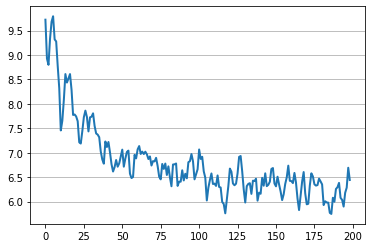

In [329]:
history = loss_tr
plt.plot(np.convolve(np.ones(3)/3,np.log(history),mode='valid'), linewidth=2)
plt.grid(axis='y')
plt.show()

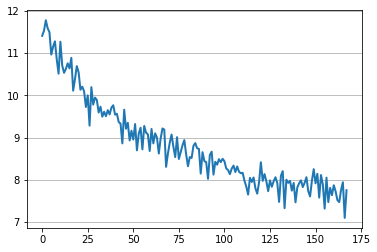

In [137]:
history = loss_tr
plt.plot(np.log(history), linewidth=2)
plt.grid(axis='y')
plt.show()

In [330]:
params = pyro.get_param_store()
F = params["auto_F"].detach()
G = params["auto_G"].detach()
H = params["auto_H"].detach()
b = params["auto_b"].detach()
Q = params["auto_Q"].detach()
R = params["auto_R"].detach()

In [331]:
F

tensor([[0.7175]])

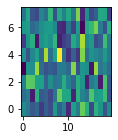

In [332]:
plt.figure(figsize=(3,2))
plt.imshow(G.reshape(8,20), aspect=3, origin='ll')
plt.show()

In [333]:
x0 = torch.zeros(1)
x, z = [], []
for t in range(6000):
    x += [G.reshape(ldim,udim) @ U[0][t,:] + F.reshape(ldim,ldim) @ (x0 if t==0 else x[t-1])]
    z += [H.reshape(zdim,ldim) @ x[t]]
x, z = torch.stack(x), torch.stack(z)
x.shape, z.shape

(torch.Size([6000, 1]), torch.Size([6000, 65]))

tensor([0.6769, 0.7061, 0.6590, 0.5332, 0.3218, 0.6612, 0.7542, 0.7477, 0.7199,
        0.4769, 0.5956, 0.6394, 0.6921, 0.7158, 0.6630, 0.6101, 0.7199, 0.7391,
        0.7511, 0.7175, 0.6777, 0.6972, 0.3297, 0.3764, 0.3801, 0.4427, 0.5188,
        0.4991, 0.4852, 0.5170, 0.3109, 0.2711, 0.3245, 0.5417, 0.5931, 0.5517,
        0.5926, 0.4151, 0.5553, 0.3698, 0.3810, 0.3922, 0.4250, 0.5203, 0.5112,
        0.6236, 0.6326, 0.4644, 0.4380, 0.4566, 0.4417, 0.4355, 0.3020, 0.3463,
        0.2475, 0.5400, 0.6202, 0.6561, 0.3795, 0.6086, 0.5712, 0.4446, 0.4219,
        0.3554, 0.4882])
tensor(0.5270)


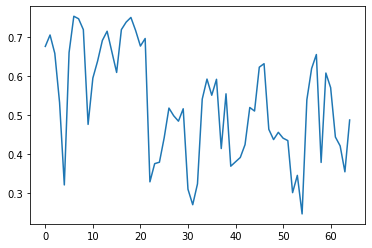

In [71]:
# With state space
plt.plot(Q.diag())
print(Q.diag())
print(Q.diag().mean())

tensor([0.3810, 0.4697, 0.4636, 0.2956, 0.2365, 0.3669, 0.3921, 0.4028, 0.4231,
        0.1470, 0.2104, 0.2756, 0.3291, 0.3569, 0.3427, 0.3008, 0.3504, 0.3749,
        0.3701, 0.3332, 0.3422, 0.3610, 0.1513, 0.1693, 0.0966, 0.2763, 0.2851,
        0.1786, 0.1780, 0.1267, 0.1046, 0.1161, 0.1631, 0.2312, 0.2999, 0.2745,
        0.2174, 0.1053, 0.3806, 0.2734, 0.2627, 0.2438, 0.2863, 0.3816, 0.3863,
        0.3513, 0.3225, 0.2791, 0.2365, 0.2651, 0.2373, 0.2150, 0.0575, 0.0855,
        0.1235, 0.3103, 0.2632, 0.2825, 0.2028, 0.3278, 0.3311, 0.2405, 0.2115,
        0.2357, 0.2959])
tensor(0.2706)


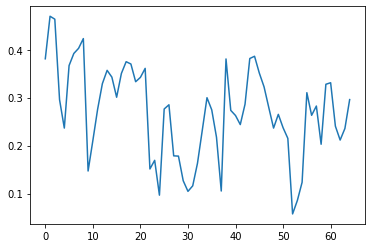

In [335]:
# With state space
plt.plot(Q.diag())
print(Q.diag())
print(Q.diag().mean())

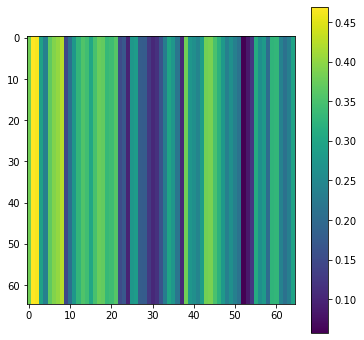

In [334]:
Q = torch.zeros(zdim,zdim)
for i in range(zdim):
    for j in range(zdim):
        Q[i,j] = sp.stats.pearsonr(z[:,i], Z[0][:6000,j])[0]

plt.figure(figsize=(6,6))
plt.imshow(torch.clamp_min(Q,0), aspect=1)
plt.colorbar()
plt.show()

Q0 = Q

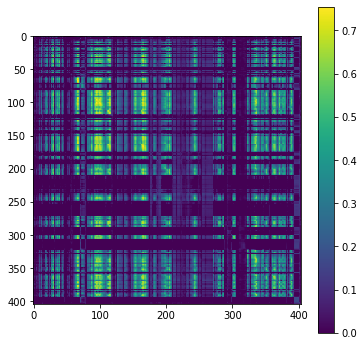

In [21]:
Q = torch.zeros(zdim,zdim)
for i in range(zdim):
    for j in range(zdim):
        Q[i,j] = sp.stats.pearsonr(z[:,i], Z[:,j])[0]

plt.figure(figsize=(6,6))
plt.imshow(torch.clamp_min(Q,0), aspect=1)
plt.colorbar()
plt.show()

Q0 = Q

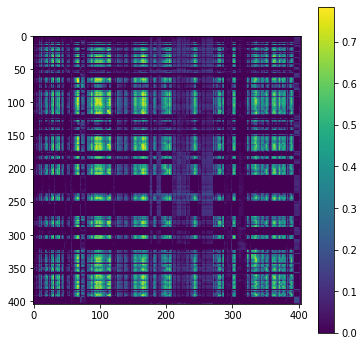

In [578]:
Q = torch.zeros(zdim,zdim)
for i in range(zdim):
    for j in range(zdim):
        Q[i,j] = sp.stats.pearsonr(z[:,i], Z[:,j])[0]

plt.figure(figsize=(6,6))
plt.imshow(torch.clamp_min(Q,0), aspect=1)
plt.colorbar()
plt.show()

Q0 = Q

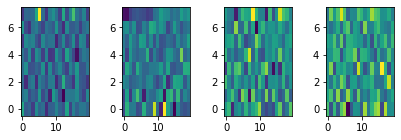

In [565]:
G = params['auto_input_transition'].detach().reshape(32,8,20)
plt.figure(figsize=(7,2))
plt.subplot(141); plt.imshow(G[0], aspect=4, origin='ll')
plt.subplot(142); plt.imshow(G[1], aspect=4, origin='ll')
plt.subplot(143); plt.imshow(G[2], aspect=4, origin='ll')
plt.subplot(144); plt.imshow(G[3], aspect=4, origin='ll');

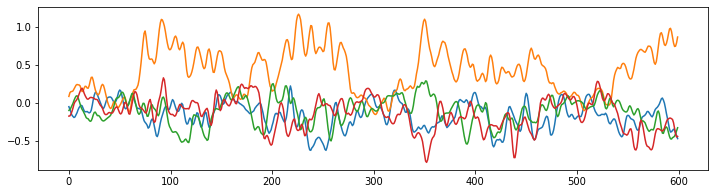

In [577]:
plt.figure(figsize=(12,3))
plt.plot(torch.cat([params[f'auto_state_{i}'] for i in range(600)]).detach().reshape(-1,32));

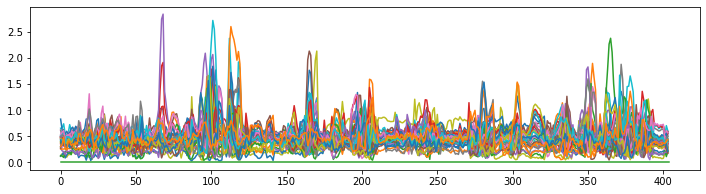

In [567]:
params = pyro.get_param_store()
filt = params['auto_measurement_transition'].detach().reshape(-1,32)
plt.figure(figsize=(12,3))
plt.plot(filt); plt.plot([0,zdim],[0,0]);
# plt.figure(figsize=(4,2)); plt.imshow(filt.reshape(zdim,1), aspect=4, origin='ll');
# plt.colorbar();

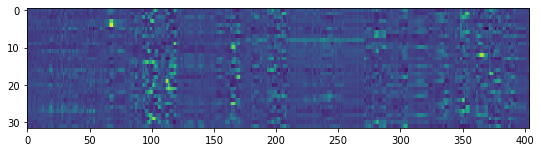

In [575]:
plt.figure(figsize=(9,4))
plt.imshow(sp.stats.zscore(filt).T, aspect=3);

In [576]:
params = pyro.get_param_store()
params['auto_state_transition'].detach()

tensor([0.8694, 0.8516, 0.8983, 0.9204, 0.8701, 0.7857, 0.9331, 0.8201, 0.9667,
        0.8175, 0.9415, 0.8834, 0.9226, 0.8121, 0.9508, 0.8211, 0.8118, 0.8215,
        0.8312, 0.8371, 0.8134, 0.9232, 0.9030, 0.8545, 0.8424, 0.9312, 0.8391,
        0.9183, 0.9231, 0.8548, 0.8825, 0.8794])

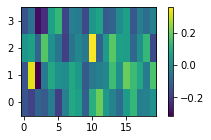

In [230]:
params = pyro.get_param_store()
filt = params['auto_input_transition'].detach()
# plt.plot(filt);
plt.figure(figsize=(4,2)); plt.imshow(filt.reshape(udim//window,window), aspect=4, origin='ll');
plt.colorbar();

In [ ]:
plt.plot([sp.stats.pearsonr(Z.flatten(), U[:,i])[0] for i in range(udim)])
plt.plot([sp.stats.pearsonr(Z.flatten(), U @ filt)[0] for i in range(udim)])
plt.xticks(range(0,udim,5),range(1,udim+1,5))
plt.grid(axis='x')
plt.show()

In [ ]:
params['auto_loc'][0].item(), params['auto_scale'][0].item()

In [ ]:
plt.figure(figsize=(5,6))
plt.subplot(211)
plt.plot(params['auto_loc'][1:21].detach())
plt.subplot(212)
plt.plot(params['auto_scale'][1:21].detach());

In [ ]:
params = pyro.get_param_store()
print('F:', [_.item() for _ in params['auto_state_transition']])
print('G:', [_.item() for _ in params['auto_input_transition']])
print('H:', [_.item() for _ in params['auto_measurement_transition']])

In [ ]:
S = np.array([pyro.get_param_store()[f'auto_state_{_}'].item() for _ in range(500)])
plt.plot(S)
plt.plot(Z[0]/3);

sp.stats.pearsonr(S, Z[0].flatten().numpy())

In [186]:
for name, value in pyro.get_param_store().items():
    if not name.startswith('auto_state_'):
        print(name, pyro.param(name).shape)

auto_F_loc torch.Size([1, 1])
auto_G_loc torch.Size([1])
auto_input_transition torch.Size([1])
auto_H_loc torch.Size([1])
auto_measurement_transition torch.Size([1])
auto_X_init torch.Size([1, 1])


In [236]:
minmax = lambda name: print(f'{name}: {min(pyro.get_param_store()[name]).item():.3f}, {max(pyro.get_param_store()[name]).item():.3f}')

minmax('auto_F_loc')
minmax('auto_G_loc')
minmax('auto_H_loc')
minmax('auto_X_init')
minmax('auto_input_transition')
minmax('auto_measurement_transition')

auto_F_loc: 0.575, 0.575
auto_G_loc: 0.057, 0.057
auto_H_loc: 0.149, 0.149
auto_X_init: 0.078, 0.078
auto_input_transition: 0.317, 0.317
auto_measurement_transition: 2.855, 2.855


In [ ]:
plt.plot(history[0])
plt.plot(history[1])
plt.legend(('true','estimate'), fontsize=12)
plt.show()

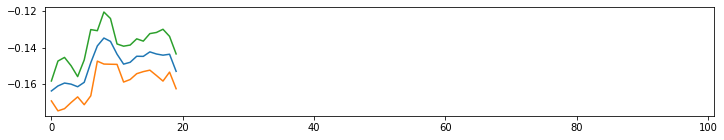

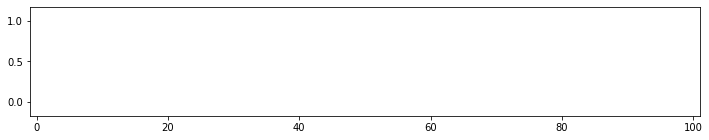

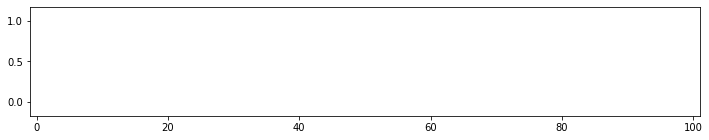

In [245]:
loc = pyro.param('kernel_loc').detach().cpu()
scale = pyro.param('kernel_scale').detach().cpu()
for i in range(3):
    plt.figure(figsize=(12,2))
    plt.plot(loc[i*100:(i+1)*100])
    plt.plot(loc[i*100:(i+1)*100]-scale[i*100:(i+1)*100])
    plt.plot(loc[i*100:(i+1)*100]+scale[i*100:(i+1)*100])
    plt.xlim(-1,101)
    plt.show()

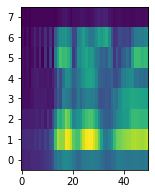

In [206]:
plt.figure(figsize=(3,3))
plt.imshow(X[0][95,:].reshape(-1,window), aspect=8, origin='ll')
plt.show()

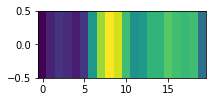

In [246]:
plt.figure(figsize=(3,3))
plt.imshow(pyro.param('kernel_loc').reshape(-1,window).detach().cpu(), aspect=8, origin='ll')
plt.show()

In [247]:
pyro.param('kernel_loc').detach(), pyro.param('memory_loc').detach(), pyro.param('readout_loc').detach()

(tensor([-0.1637, -0.1609, -0.1593, -0.1599, -0.1614, -0.1590, -0.1482, -0.1390,
         -0.1347, -0.1366, -0.1436, -0.1490, -0.1480, -0.1447, -0.1448, -0.1423,
         -0.1435, -0.1441, -0.1436, -0.1529]),
 tensor([0.3259]),
 tensor([0.2483]))

(-0.494118617229904, 3.860443390875746e-32)

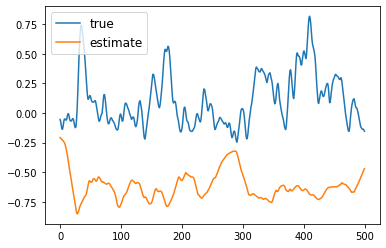

In [248]:
x, y = X_test[1], Y_test[1]
z = model.filter(x)
z = z.detach().cpu()
plt.plot(y[:500])
plt.plot(z[:500])
plt.legend(('true','estimate'), fontsize=12)
sp.stats.pearsonr(y, z)

In [ ]:
# from pyro.contrib.tracking.extended_kalman_filter import EKFState
# from pyro.contrib.tracking.distributions import EKFDistribution
# from pyro.contrib.tracking.dynamic_models import NcvContinuous
# from pyro.contrib.tracking.measurements import PositionMeasurement


# def model(x, y):
#     weight_x1 = pyro.sample('weight_x1', dist.Normal(0, 1))
#     weight_x2 = pyro.sample('weight_x2', dist.Normal(0, 1))
#     bias = pyro.sample('bias', dist.Normal(5, 1))
    
#     with pyro.plate('observations'):
#         target = pyro.sample('obs', dist.Normal(x[:, 0] * weight_x1 + x[:, 1] * weight_x2 + bias, 1), obs=y)

# guide = pyro.infer.autoguide.AutoDiagonalNormal(model)
# optim = pyro.optim.Adam({"lr": 0.005})
# svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=1000)

# def train(num_iterations):
#     pyro.clear_param_store()
#     for j in range(num_iterations):
#         loss = svi.step(x, y)
#         if j % 500 == 0:
#             print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x)))

# train(5000)


# for name, value in pyro.get_param_store().items():
#     print(name, pyro.param(name))

In [ ]:
# Continuous model
ncv = NcvContinuous(dim, 2.0)

# Truth trajectory
xs_truth = torch.zeros(num_frames, dim)
xs_truth[:,:1] = X

In [ ]:
# # Measurements
# measurements = []
# mean = torch.zeros(2)
# # no correlations
# cov = 1e-5 * torch.eye(2)
# with torch.no_grad():
#     # sample independent measurement noise
#     dzs = pyro.sample('dzs', dist.MultivariateNormal(mean, cov).expand((num_frames,)))
#     # compute measurement means
#     zs = xs_truth[:, :2] + dzs

# Measurements
# zs = torch.cat((X, y), 1)
zs = y

In [ ]:
def model(data):
    # a HalfNormal can be used here as well
    R = pyro.sample('pv_cov', dist.HalfCauchy(2e-6)) * torch.eye(2)
    Q = pyro.sample('measurement_cov', dist.HalfCauchy(1e-6)) * torch.eye(1)
    # observe the measurements
    pyro.sample('track_{}'.format(i), EKFDistribution(xs_truth[0], R, ncv, Q, time_steps=num_frames), obs=data)

guide = pyro.infer.autoguide.AutoDelta(model)  # MAP estimation

In [ ]:
optim = pyro.optim.Adam({'lr': 2e-1})
svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(retain_graph=True))

# pyro.set_rng_seed(0)
pyro.clear_param_store()

for i in range(250):
    loss = svi.step(zs)
    if not i % 10:
        print('loss: ', loss)

In [ ]:
# retrieve states for visualization
R = guide()['pv_cov'] * torch.eye(2)
Q = guide()['measurement_cov'] * torch.eye(1)
ekf_dist = EKFDistribution(xs_truth[0], R, ncv, Q, time_steps=num_frames)
states = ekf_dist.filter_states(zs)

In [ ]:
list(ncv.parameters())

In [ ]:
S = np.stack([_.mean.detach().cpu().numpy() for _ in states])
S.shape

In [ ]:
plt.plot(S);

In [ ]:
np.corrcoef(S.T)[0,1]

In [87]:
# class KalmanFilter(nn.Module):
#     def __init__(self, udim, xdim, zdim):
#         super().__init__()
#         self.udim = udim
#         self.xdim = xdim
#         self.zdim = zdim
    
#     def forward(self, u, z):
#         # a HalfNormal can be used here as well
#         Q = pyro.sample('state_cov', dist.HalfCauchy(2e-6)) * torch.eye(self.xdim)
#         R = pyro.sample('measurement_cov', dist.HalfCauchy(1e-6)) * torch.eye(self.zdim)
        
#         # State transition matrix
#         F_loc = pyro.sample('F_loc', dist.MultivariateNormal(torch.zeros(self.xdim*self.xdim), torch.eye(self.xdim*self.xdim)))
#         F_scale = pyro.sample('F_scale', dist.HalfCauchy(1e-6)) * torch.eye(self.xdim*self.xdim)
#         F = pyro.sample('state_transition', dist.MultivariateNormal(F_loc, F_scale)).reshape(self.xdim,self.xdim)
        
#         # External input transition matrix
#         G_loc = pyro.sample('G_loc', dist.MultivariateNormal(torch.zeros(self.xdim*self.udim), torch.eye(self.xdim*self.udim)))
#         G_scale = pyro.sample('G_scale', dist.HalfCauchy(1e-6)) * torch.eye(self.xdim*self.udim)
#         G = pyro.sample('input_transition', dist.MultivariateNormal(G_loc, G_scale)).reshape(self.xdim,self.udim)
        
#         # Measurement transition matrix
#         H_loc = pyro.sample('H_loc', dist.MultivariateNormal(torch.zeros(self.zdim*self.xdim), torch.eye(self.zdim*self.xdim)))
#         H_scale = pyro.sample('H_scale', dist.HalfCauchy(1e-6)) * torch.eye(self.zdim*self.xdim)
#         H = pyro.sample('measurement_transition', dist.MultivariateNormal(H_loc, H_scale)).reshape(self.zdim,self.xdim)
        
#         # Prepare time series variables
#         time_steps = len(u)
#         X = torch.zeros(time_steps, self.xdim)
#         P = torch.zeros(time_steps, self.xdim, self.xdim)
#         Z = torch.zeros(time_steps, self.zdim)
        
#         # Initialize state
#         X0 = pyro.sample('X_init', dist.Normal(torch.zeros(self.xdim), torch.eye(self.xdim)))
#         P0 = pyro.sample('P_init', dist.HalfCauchy(2e-6)) * torch.eye(self.xdim)
        
#         for t in range(time_steps):
#             # Predict next step
#             if t == 0:
#                 X[t,:] = pyro.sample(f'state_{t}', dist.Normal(F @ X0 + G @ u[t,:], Q))
#                 P[t,:,:] = F @ P0 @ F.transpose(-1,-2) + Q
#             else:
#                 X[t,:] = pyro.sample(f'state_{t}', dist.Normal(F @ X[t-1,:] + G @ u[t,:], Q))
#                 P[t,:,:] = F @ P[t-1,:,:] @ F.transpose(-1,-2) + Q
            
#             # Calculate Kalman gain
#             S = H @ P[t,:,:] @ H.transpose(-1,-2) + R
#             #K = P[t,:,:] @ H.transpose(-1,-2) @ S^-1
#             K_prefix = P[t,:,:] @ H.transpose(-1,-2)
            
#             # Measurement torch.solve()[0]
#             Z[t,:] = pyro.sample(f'obs_{t}', dist.Normal(H @ X[t,:], R), obs=z[t,:])
            
#             # Adjust by measurement
#             #P[t,:] = (torch.eye(self.xdim) - K @ H) @ P[t,:]
#             P[t,:] = (torch.eye(self.xdim) - K_prefix @ torch.solve(H, S)[0]) @ P[t,:]
#             #X[t,:] = X[t,:] + K @ (z[t,:] - H @ X[t,:])
#             X[t,:] = X[t,:] + (K_prefix @ torch.solve((z[t,:] - H @ X[t,:]).unsqueeze(1), S)[0]).squeeze(1)
    
#     def guide(self):
#         return pyro.infer.autoguide.AutoDelta(self.forward)
    
#     def filter(self, x):
#         raise NotImplementedError("Forward filtering not yet implemented!")